# Object Detection Model (for Pump Impellers)

Here, we fine-tune __RetinaNet__ (with __ResNet50__ Backbone) to detect the presence of pump impellers in images. 

_This model is used to detect & segment out the pump impellers so that defects can be detected in them_

__Dataset:__ An augmented subset of [Submersible Pump Impeller Defect Dataset](https://www.kaggle.com/ravirajsinh45/real-life-industrial-dataset-of-casting-product) (so as to include multiple impellers in a single image, for effective detection)

## Preliminaries

In [26]:
import os
os.chdir("/content/drive/My Drive/ME781 Project")

### Clone the RetinaNet repository & install all dependencies

In [ ]:
!git clone https://github.com/fizyr/keras-retinanet.git
os.chdir("keras-retinanet")

!pip install . --user

In [29]:
!python setup.py build_ext --inplace

running build_ext
skipping 'keras_retinanet/utils/compute_overlap.c' Cython extension (up-to-date)
copying build/lib.linux-x86_64-3.6/keras_retinanet/utils/compute_overlap.cpython-36m-x86_64-linux-gnu.so -> keras_retinanet/utils


In [30]:
!pip install keras_resnet

## Dataset Preparation

A dataset of 12 images (these many are sufficient for object detection, since only 1 class is involved) is prepared, such that each image contains 1 or more pump impellers. All these images are annotated using [labelmg](https://github.com/tzutalin/labelImg).

This dataset is split into training & testing sets. For training, two CSV files are needed. The first one containing the path, bounding box and class name of each image (`train.csv`). The second file should only contain the class name and their mapping (`class.csv`).

The CSV file with annotations should contain one annotation per line. Images with multiple bounding boxes should use one row per bounding box. Note that indexing for pixel values starts at 0.

In [31]:
from bs4 import BeautifulSoup
from imutils import paths
import argparse
import random

In [32]:
annot_path = "/content/drive/My Drive/ME781 Project/object_detection/annotations"
images_path = "/content/drive/My Drive/ME781 Project/object_detection/images"
train_csv = "/content/drive/My Drive/ME781 Project/object_detection/train.csv"
test_csv = "/content/drive/My Drive/ME781 Project/object_detection/test.csv"
classes_csv = "/content/drive/My Drive/ME781 Project/object_detection/classes.csv"
train_test_split = 0.8

# grab all image paths then construct the training and testing split
imagePaths = list(paths.list_files(images_path))
random.shuffle(imagePaths)
i = int(len(imagePaths) * train_test_split)
trainImagePaths = imagePaths[:i]
testImagePaths = imagePaths[i:]

# create the list of datasets to build
dataset = [ ("train", trainImagePaths, train_csv),
            ("test", testImagePaths, test_csv)]

# initialize the set of classes we have
CLASSES = set()

# loop over the datasets
for (dType, imagePaths, outputCSV) in dataset:
    # load the contents
    print ("[INFO] creating '{}' set...".format(dType))
    print ("[INFO] {} total images in '{}' set".format(len(imagePaths), dType))

    # open the output CSV file
    csv = open(outputCSV, "w")

    # loop over the image paths
    for imagePath in imagePaths:
        # build the corresponding annotation path
        fname = imagePath.split(os.path.sep)[-1]
        fname = "{}.xml".format(fname[:fname.rfind(".")])
        annotPath = os.path.sep.join([annot_path, fname])

        # load the contents of the annotation file and buid the soup
        contents = open(annotPath).read()
        soup = BeautifulSoup(contents, "html.parser")

        # extract the image dimensions
        w = int(soup.find("width").string)
        h = int(soup.find("height").string)

        # loop over all object elements
        for o in soup.find_all("object"):
            #extract the label and bounding box coordinates
            label = o.find("name").string
            xMin = int(float(o.find("xmin").string))
            yMin = int(float(o.find("ymin").string))
            xMax = int(float(o.find("xmax").string))
            yMax = int(float(o.find("ymax").string))

            # truncate any bounding box coordinates that fall outside
            # the boundaries of the image
            xMin = max(0, xMin)
            yMin = max(0, yMin)
            xMax = min(w, xMax)
            yMax = min(h, yMax)

            # ignore the bounding boxes where the minimum values are larger
            # than the maximum values and vice-versa due to annotation errors
            if xMin >= xMax or yMin >= yMax:
                continue
            elif xMax <= xMin or yMax <= yMin:
                continue

            # write the image path, bb coordinates, label to the output CSV
            row = [os.path.abspath(imagePath),str(xMin), str(yMin), str(xMax),
                    str(yMax), str(label)]
            csv.write("{}\n".format(",".join(row)))

            # update the set of unique class labels
            CLASSES.add(label)

    # close the CSV file
    csv.close()

# write the classes to file
print("[INFO] writing classes...")
csv = open(classes_csv, "w")
rows = [",".join([c, str(i)]) for (i,c) in enumerate(CLASSES)]
csv.write("\n".join(rows))
csv.close()

[INFO] creating 'train' set...
[INFO] 9 total images in 'train' set
[INFO] creating 'test' set...
[INFO] 3 total images in 'test' set
[INFO] writing classes...


## Model Training (Fine-tuning)

In [33]:
# Set the environment variable so as to enable the use of GPU
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [34]:
# Train the model for 20 epochs
# Model weights after each epoch are stored as snapshots in the `./snapshots/` directory

!python keras_retinanet/bin/train.py --steps 9 --epochs 20 csv "/content/drive/My Drive/ME781 Project/object_detection/train.csv" "/content/drive/My Drive/ME781 Project/object_detection/classes.csv"

2020-11-03 10:17:41.248078: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-11-03 10:17:50.852352: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 10:17:50.856970: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 10:17:50.857305: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-11-03 10:17:50.857348: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 10:17:50.863523: I 

In [50]:
# The best model among the snapshots has to be converted in a format which can be used for prediction.

!python keras_retinanet/bin/convert_model.py ./snapshots/resnet50_csv_19.h5 "/content/drive/My Drive/ME781 Project/object_detection/pump_impeller_detection_retinanet.h5"

2020-11-03 10:52:45.483090: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 10:52:46.952131: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-03 10:52:46.955701: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-03 10:52:46.956034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-11-03 10:52:46.956079: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-03 10:52:46.957818: I tensorflow/stream_executor/platform/defaul

## Predictions by Model

In [36]:
from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

# import miscellaneous modules
import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

In [37]:
model_path = "/content/drive/My Drive/ME781 Project/object_detection/pump_impeller_detection_retinanet.h5"
model = models.load_model(model_path, backbone_name='resnet50')

In [38]:
THRESH_SCORE = 0.8                      # Threshold confidence above which the bounding box will be considered
labels_to_names = {0: "pump_impeller"}

# Function to identify pump impellers in an image & create bounding boxes around them
def img_inference(img_path):
    image = read_image_bgr(img_path)

    # copy to draw on
    draw = image.copy()
    draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

    # preprocess image for network
    image = preprocess_image(image)
    image, scale = resize_image(image)

    # process image
    start = time.time()
    boxes, scores, labels = model.predict_on_batch(np.expand_dims(image, axis=0))
    print("processing time: ", time.time() - start)

    # correct for image scale
    boxes /= scale

    # visualize detections
    for box, score, label in zip(boxes[0], scores[0], labels[0]):
        # scores are sorted so we can break
        if score < THRESH_SCORE:
            break

        color = label_color(label)

        b = box.astype(int)
        draw_box(draw, b, color=color)

        caption = "{} {:.3f}".format(labels_to_names[label], score)
        print(caption)
        draw_caption(draw, b, caption)

    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(draw)
    plt.show()

processing time:  0.09543013572692871
pump_impeller 0.946


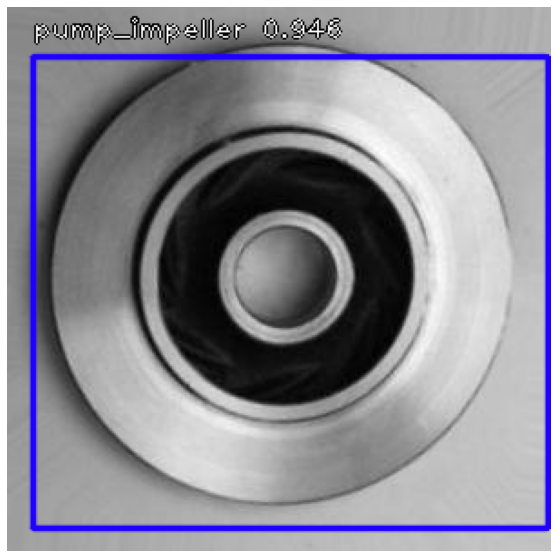

In [47]:
img_inference("/content/drive/My Drive/ME781 Project/object_detection/images/img_7.jpeg")

processing time:  0.10008001327514648
pump_impeller 0.955


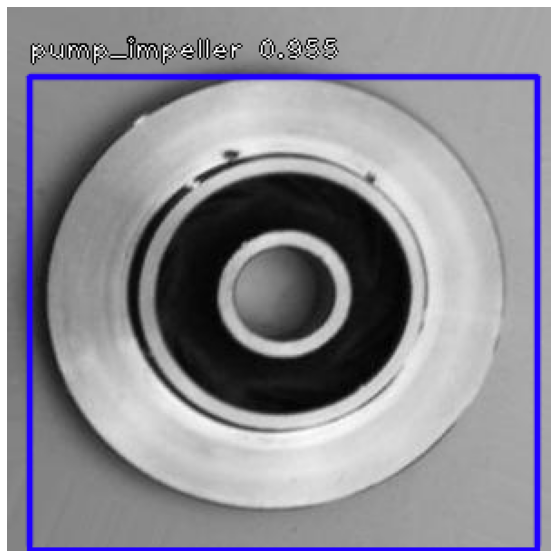

In [46]:
img_inference("/content/drive/My Drive/ME781 Project/object_detection/images/img_10.jpeg")

processing time:  0.09685707092285156
pump_impeller 0.912
pump_impeller 0.902
pump_impeller 0.896
pump_impeller 0.893


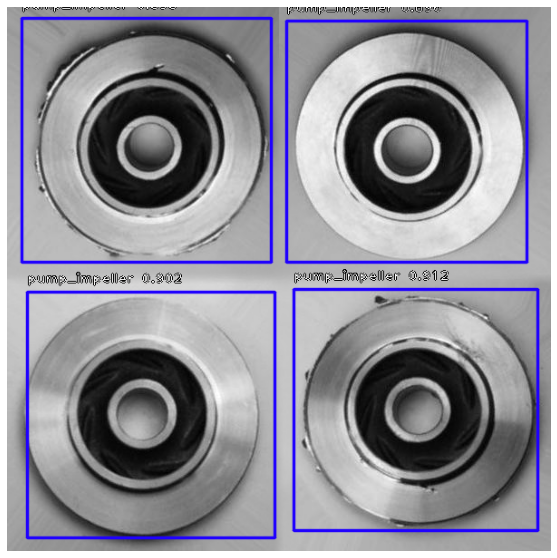

In [43]:
img_inference("/content/drive/My Drive/ME781 Project/object_detection/images/img_6.jpg")

processing time:  0.10018157958984375
pump_impeller 0.918
pump_impeller 0.915
pump_impeller 0.906
pump_impeller 0.899
pump_impeller 0.887
pump_impeller 0.872
pump_impeller 0.854
pump_impeller 0.844
pump_impeller 0.811


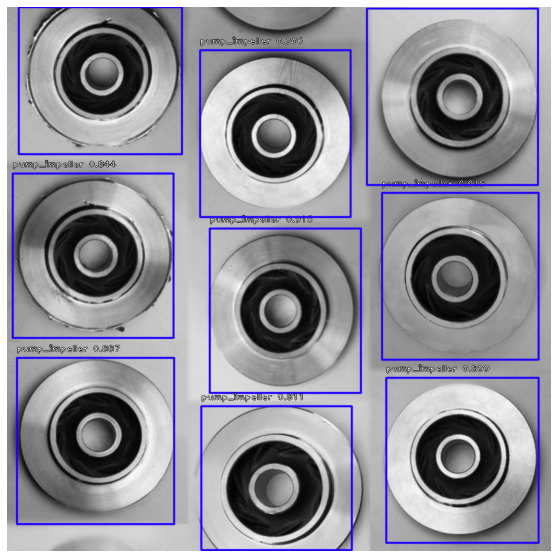

In [48]:
img_inference("/content/drive/My Drive/ME781 Project/object_detection/images/img_3.jpg")